# ResNet implementation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as nnf
import torchvision
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.model_selection import train_test_split

## Loading the CIFAR100 dataset

In [3]:
transform_train = transforms.Compose([
     transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(15),
     transforms.ToTensor(),
     transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
     transforms.RandomErasing(p=0.5)
     ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

batch_size = 128

full_set = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True)

train_size = int(0.8 * len(full_set))
valid_size = len(full_set) - train_size

trainset, validset = torch.utils.data.random_split(full_set, [train_size, valid_size])

trainset.dataset.transform = transform_train
validset.dataset.transform = transform_test

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]


In [4]:
class_names = trainset.dataset.classes
print(class_names)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

## Preparing the device

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Implementing the structure of the ResNet

In [6]:
class BasicResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.conv1 = nn.Conv2d(self.in_channels, self.out_channels, 3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(self.out_channels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(self.out_channels, self.out_channels, 3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(self.out_channels)
    self.downsampling = None

    if stride != 1 or self.in_channels != self.out_channels:
      self.downsampling = nn.Sequential(
          nn.Conv2d(self.in_channels, self.out_channels, 1, stride=stride, bias=False),
          nn.BatchNorm2d(self.out_channels)
      )

  def forward(self, x):
    x0 = x if self.downsampling is None else self.downsampling(x)
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x += x0
    x = self.relu(x)
    return x

In [7]:
class BottleneckBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.bottleneck_channels = self.out_channels // 4
    self.conv1 = nn.Conv2d(self.in_channels, self.bottleneck_channels, 1, stride=stride, bias=False)
    self.bn1 = nn.BatchNorm2d(self.bottleneck_channels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(self.bottleneck_channels, self.bottleneck_channels, 3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(self.bottleneck_channels)
    self.conv3 = nn.Conv2d(self.bottleneck_channels, self.out_channels, 1, stride=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.out_channels)
    self.downsampling = None

    if stride != 1 or self.in_channels != self.out_channels:
      self.downsampling = nn.Sequential(
          nn.Conv2d(self.in_channels, self.out_channels, 1, stride=stride, bias=False),
          nn.BatchNorm2d(self.out_channels)
      )

  def forward(self, x):
    x0 = x if self.downsampling is None else self.downsampling(x)
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x += x0
    x = self.relu(x)
    return x

In [8]:
class ResNet(nn.Module):
  def __init__(self, starting_layers, blocks, number_of_classes):
    super().__init__()

    self.number_of_classes = number_of_classes
    self.resnet = nn.ModuleList(starting_layers + blocks)
    self.last_layer = nn.Linear(blocks[-1].out_channels, self.number_of_classes)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

  def forward(self, x):
    for layer in self.resnet:
      x = layer(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.last_layer(x)
    return x

## ResNet-34 training loop

In [9]:
starting_layers = [
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU()
]

blocks = [
    BasicResidualBlock(in_channels=64, out_channels=64),
    BasicResidualBlock(in_channels=64, out_channels=64),
    BasicResidualBlock(in_channels=64, out_channels=64),
    BasicResidualBlock(in_channels=64, out_channels=128, stride=2),
    BasicResidualBlock(in_channels=128, out_channels=128),
    BasicResidualBlock(in_channels=128, out_channels=128),
    BasicResidualBlock(in_channels=128, out_channels=128),
    BasicResidualBlock(in_channels=128, out_channels=256, stride=2),
    BasicResidualBlock(in_channels=256, out_channels=256),
    BasicResidualBlock(in_channels=256, out_channels=256),
    BasicResidualBlock(in_channels=256, out_channels=256),
    BasicResidualBlock(in_channels=256, out_channels=256),
    BasicResidualBlock(in_channels=256, out_channels=256),
    BasicResidualBlock(in_channels=256, out_channels=512, stride=2),
    BasicResidualBlock(in_channels=512, out_channels=512),
    BasicResidualBlock(in_channels=512, out_channels=512),
]

model = ResNet(starting_layers, blocks, len(class_names))
print(model)
model = model.to(device)

ResNet(
  (resnet): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3-5): 3 x BasicResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (6): BasicResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2

In [10]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=280)

In [11]:
n_epochs = 300

In [12]:
training_losses = []
valid_losses = []
learning_rates = []
best_valid_loss = np.inf

for epoch in range(n_epochs):
  model.train()

  total_loss = 0.0
  n_batches = 0

  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    n_batches += 1

  training_losses.append(total_loss / n_batches)
  scheduler.step()
  learning_rates.append(scheduler.get_last_lr())

  model.eval()

  with torch.no_grad():
    total_loss = 0.0
    n_batches = 0

    for i, data in enumerate(validloader, 0):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = loss_function(outputs, labels)

      total_loss += loss.item()
      n_batches += 1

    avg_valid_loss = total_loss / n_batches
    valid_losses.append(avg_valid_loss)

  print(f"Finished epoch: {epoch + 1} / {n_epochs}: loss = {training_losses[-1]} val_loss = {valid_losses[-1]}")

  if avg_valid_loss < best_valid_loss:
      best_valid_loss = avg_valid_loss
      torch.save(model.state_dict(), "best_model.pt")

Finished epoch: 1 / 300: loss = 4.236639931559943 val_loss = 3.846272103394134
Finished epoch: 2 / 300: loss = 3.6241718298330095 val_loss = 3.3965881746026536
Finished epoch: 3 / 300: loss = 3.1502654308709093 val_loss = 3.1218578483484967
Finished epoch: 4 / 300: loss = 2.778807976756233 val_loss = 2.7794897737382334
Finished epoch: 5 / 300: loss = 2.422356679416693 val_loss = 2.5801364289054387
Finished epoch: 6 / 300: loss = 2.1050234118970437 val_loss = 2.234739966030362
Finished epoch: 7 / 300: loss = 1.8330539392587095 val_loss = 2.2909876485414142
Finished epoch: 8 / 300: loss = 1.5974059714295994 val_loss = 2.21336538127706
Finished epoch: 9 / 300: loss = 1.3815105346064218 val_loss = 2.1039157411720177
Finished epoch: 10 / 300: loss = 1.2055500157344075 val_loss = 2.1745054148420504
Finished epoch: 11 / 300: loss = 1.0727976175923697 val_loss = 2.28659743447847
Finished epoch: 12 / 300: loss = 0.9354599285811281 val_loss = 2.2927320848537396
Finished epoch: 13 / 300: loss = 0

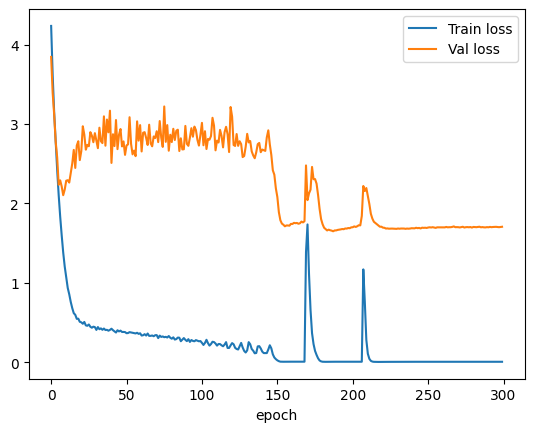

In [13]:
plt.plot(training_losses, label="Train loss")
plt.plot(valid_losses, label="Val loss")
plt.legend()
plt.xlabel("epoch")
plt.show()

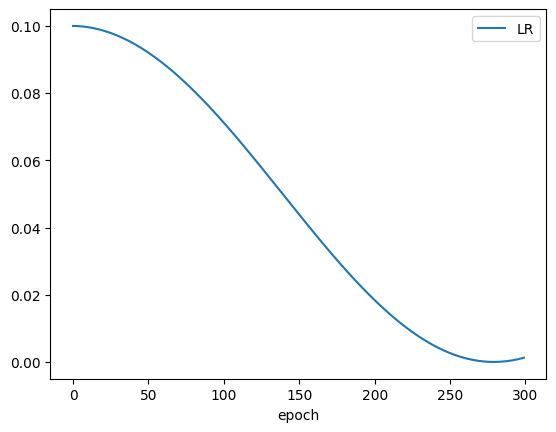

In [15]:
plt.plot(learning_rates, label="LR")
plt.legend()
plt.xlabel("epoch")
plt.show()

In [14]:
correct = 0
total = 0

model.load_state_dict(torch.load("best_model.pt"))
model.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the test set: {100 * correct / total} %")

Accuracy of the network on the test set: 59.22 %


## ResNet-56 training loop

In [ ]:
starting_layers = [
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.ReLU()
]

blocks = [
    BasicResidualBlock(in_channels=16, out_channels=16),
    BasicResidualBlock(in_channels=16, out_channels=16),
    BasicResidualBlock(in_channels=16, out_channels=16),
    BasicResidualBlock(in_channels=16, out_channels=16),
    BasicResidualBlock(in_channels=16, out_channels=16),
    BasicResidualBlock(in_channels=16, out_channels=16),
    BasicResidualBlock(in_channels=16, out_channels=16),
    BasicResidualBlock(in_channels=16, out_channels=16),
    BasicResidualBlock(in_channels=16, out_channels=16),
    BasicResidualBlock(in_channels=16, out_channels=32, stride=2),
    BasicResidualBlock(in_channels=32, out_channels=32),
    BasicResidualBlock(in_channels=32, out_channels=32),
    BasicResidualBlock(in_channels=32, out_channels=32),
    BasicResidualBlock(in_channels=32, out_channels=32),
    BasicResidualBlock(in_channels=32, out_channels=32),
    BasicResidualBlock(in_channels=32, out_channels=32),
    BasicResidualBlock(in_channels=32, out_channels=32),
    BasicResidualBlock(in_channels=32, out_channels=32),
    BasicResidualBlock(in_channels=32, out_channels=64, stride=2),
    BasicResidualBlock(in_channels=64, out_channels=64),
    BasicResidualBlock(in_channels=64, out_channels=64),
    BasicResidualBlock(in_channels=64, out_channels=64),
    BasicResidualBlock(in_channels=64, out_channels=64),
    BasicResidualBlock(in_channels=64, out_channels=64),
    BasicResidualBlock(in_channels=64, out_channels=64),
    BasicResidualBlock(in_channels=64, out_channels=64),
    BasicResidualBlock(in_channels=64, out_channels=64)
]

model = ResNet(starting_layers, blocks, len(class_names))
print(model)
model = model.to(device)

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=280)

In [ ]:
n_epochs = 300

In [ ]:
training_losses = []
valid_losses = []
best_valid_loss = np.inf

for epoch in range(n_epochs):
  model.train()

  total_loss = 0.0
  n_batches = 0

  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    n_batches += 1

  training_losses.append(total_loss / n_batches)
  scheduler.step()

  model.eval()

  with torch.no_grad():
    total_loss = 0.0
    n_batches = 0

    for i, data in enumerate(validloader, 0):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = loss_function(outputs, labels)

      total_loss += loss.item()
      n_batches += 1

    avg_valid_loss = total_loss / n_batches
    valid_losses.append(avg_valid_loss)

  print(f"Finished epoch: {epoch + 1} / {n_epochs}: loss = {training_losses[-1]} val_loss = {valid_losses[-1]}")

  if avg_valid_loss < best_valid_loss:
      best_valid_loss = avg_valid_loss
      torch.save(model.state_dict(), "best_model.pt")

## Evaluation

In [ ]:
plt.plot(training_losses, label="Train loss")
plt.plot(valid_losses, label="Val loss")
plt.legend()
plt.xlabel("epoch")
plt.show()

In [ ]:
correct = 0
total = 0

model.load_state_dict(torch.load("best_model.pt"))
model.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the test set: {100 * correct / total} %")